# Generalized Mutual Information

We compute the generalized mutual information on the noisy-label MNIST problem

# Reference problem

We define a very easy classification problem
in order to calibrate the scale of MMD and Wasserstein divergences,
since those divergences are not expressed in nats.

In [10]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', default=False,
                    help='For Saving the current Model')
parser.add_argument('--dataset', required=True, choices=['mnist', 'svhn'], default=False,
                    help='For Saving the current Model')

args = parser.parse_args(['--dataset', 'svhn'])
#args = parser.parse_args(['--dataset', 'mnist'])
use_cuda = not args.no_cuda and torch.cuda.is_available()



def corruption_to_mi_wrong(alpha):
    return np.log(k) + np.log(1-(1-1./k)*alpha)


def corruption_to_mi(alpha, k=10.):
    p_y_true = (1-alpha) + alpha / k
    p_y_false = alpha / k + 1e-8 # prevemnt 0 alpha error
    entropy = np.log(k)
    conditional_entropy = -(p_y_true * np.log(p_y_true) + (k-1) * p_y_false * np.log(p_y_false))
    return entropy - conditional_entropy
    
#alpha = np.linspace(0, 1, 100)
#k = 10
#mi = corruption_to_mi(alpha)
#plt.plot(alpha, mi)
#plt.xlabel('Ratio of corrupted labels')
#plt.ylabel('Mutual information (nats)')


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    

class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)
        
    def forward(self, x):
        x = self.fc1(x.view(len(x), -1))
        return F.log_softmax(x, dim=1)
    
    
class FlattenLayer(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        
    def forward(self, x):
        return x.view(len(x), -1)
    
    
# Architecture loosely inspired by
# https://www.kaggle.com/olgabelitskaya/svhn-digit-recognition
class SvhnCNN(nn.Module):
    def __init__(self):
        super(SvhnCNN, self).__init__()
        self.main = nn.Sequential(
            # 32x32 - 3 channels
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 20, 4, 2, 1),
            nn.ReLU(True),
            # 16x16 - 20 channels
            nn.BatchNorm2d(20),
            nn.Conv2d(20, 32, 3, 1, 0),
            nn.ReLU(True),            
            # 14x14 - 32 channels
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),           
            # 7x7 - 32 channels
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, 1, 0),
            nn.ReLU(True),  
            # 5x5 - 64
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, 1, 0),
            nn.ReLU(True),  
            # 3x3 - 64
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 196, 3, 1, 0),
            nn.ReLU(True),  
            # 1x1 - 196,
            nn.BatchNorm2d(196),
            nn.Conv2d(196, 512, 1, 1, 0),
            nn.ReLU(True),  
            # 1x1 - 512 channels
            FlattenLayer(),            
            nn.Linear(512, 10),
            nn.LogSoftmax(1),
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
    
class SvhnLinear(nn.Module):
    def __init__(self):
        super(SvhnLinear, self).__init__()
        self.main = nn.Sequential(
            FlattenLayer(),
            nn.Linear(3*32*32, 10),
            nn.LogSoftmax(1)
        )
        
    def forward(self, x):
        x = self.main(x)
        return x
    
    
def do_epoch(args, mode, model, device, loader, optimizer=None, info=''):
    if mode=='train':
        model.train()
    else:
        model.eval()
        
    losses = []
    accuracies = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = F.nll_loss(output, target)

        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean()
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
        if mode == 'train':
            #print 'training'
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if batch_idx % args.log_interval == 0:
            print('{} Batch {}/{} Accuracy {:.3f}\tLoss: {:.3f}'.format(
                info, batch_idx, len(loader), np.mean(accuracies), np.mean(losses)))
    return losses, accuracies



# Reference problem
class ReferenceDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):
        
        self.dataset = dataset
        
        if dataset == 'mnist':
            X = torch.zeros(10, 784)
            Y = torch.arange(10)
            for i in xrange(10):
                X[i, 78*i:78*(i+1)] = 1
            X = X.view(len(X), 1, 28, 28)        

            # Repeat X and Y 6000 times
            X = np.repeat(X, 6000, 0)
            Y = np.repeat(Y, 6000, 0)
        elif dataset == 'svhn':
            X = torch.zeros(10, 3*32*32)
            Y = torch.arange(10)
            for i in xrange(10):
                X[i, 307*i:307*(i+1)] = 1
            X = X.view(len(X), 3, 32, 32)        

            # Repeat X and Y 6000 times
            X = np.repeat(X, 6000, 0)
            Y = np.repeat(Y, 6000, 0)            
        
        self.X = X
        self.Y = Y
        
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx].item()
    
    
class CorruptedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, corruption, classes=None):
        self.dataset = dataset
        self.corruption = corruption
        self.corrupted = (np.random.uniform(size=len(dataset)) < corruption)
        if classes is not None:
            raise Exception('Uniform labels not supported anymore.')
            print ('Corrupting dataset (uniform labels)')
            self.labels = np.random.randint(0, classes, len(dataset))
        else:
            print ('Corrupting dataset (SHUFFLE labels, not always uniform)')
            self.labels = np.asarray([y for x,y in self.dataset])
        np.random.shuffle(self.labels)
        self.labels = torch.LongTensor(self.labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.corrupted[idx]:
            y = self.labels[idx].item()
        return x, y
    

class UniformSVHN(torch.utils.data.Dataset):
    def __init__(self, svhn_dataset):
        # Count number of each label
        counts = []
        for i in xrange(10):
            mask = (svhn_dataset.labels==i)
            counts.append(mask.sum())
        min_count = np.min(counts)
        print('Count labels: {}'.format(counts))
        print('Keeping min labels/class: {}'.format(min_count))
        X = []
        Y = []
        for i in xrange(10):
            class_i_truncated = svhn_dataset.data[svhn_dataset.labels==i][:min_count]
            X.append(class_i_truncated)
            Y.append(np.full(min_count, i))
        X = np.concatenate(X, 0)
        Y = np.concatenate(Y, 0)

        self.X = torch.FloatTensor(X) / 255.
        self.Y = Y
        print('Data shape {} Label shape {}'.format(X.shape, Y.shape))
        
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
class MNISTWrapper(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        
    def __getitem__(self, idx):
        x, y = self.mnist_dataset[idx]
        return x, y.item()
    
    def __len__(self):
        return len(self.mnist_dataset)
            
        


#torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

if args.dataset == 'mnist':
    train_dataset = MNISTWrapper(datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           #transforms.Normalize((0.1307,), (0.3081,))
                       ])))
    test_dataset = MNISTWrapper(datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           #transforms.Normalize((0.1307,), (0.3081,))
                       ])))
elif args.dataset == 'svhn':
    nonuniform_train_dataset = datasets.SVHN('../data', split='train', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]))
    nonuniform_test_dataset = datasets.SVHN('../data', split='test', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]))
    train_dataset = UniformSVHN(nonuniform_train_dataset)
    test_dataset = UniformSVHN(nonuniform_test_dataset)
    
corruptions = np.linspace(0, 1, 5)


def make_infinite(iterator):
    while True:
        for x in iterator:
            yield x
            

def compute_divergence(Net, corruptions, epochs=10, reference=False):

    # Train Parametric
    all_train_losses = []
    all_test_losses = []
    for corruption in corruptions:

        print ('Corruption = {}'.format(corruption))

        model = Net().to(device)
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption)
            test_corrupted = CorruptedDataset(test_dataset, corruption)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)
            test_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)
           
        train_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=args.batch_size, shuffle=True, **kwargs)
        test_corrupted_loader = torch.utils.data.DataLoader(test_corrupted, batch_size=args.test_batch_size, shuffle=True, **kwargs)

        for epoch in range(1, epochs+1):
            train_losses, train_accuracies = do_epoch(args, 'train', model, device, train_corrupted_loader, 
                                                      optimizer, info='Train Epoch {}'.format(epoch))

            print ('Corruption: {}, MI: {:.2} bits / {:.2} nats'.format(corruption, corruption_to_mi(corruption), corruption_to_mi(corruption)/np.log(2)))

            test_losses, test_accuracies = do_epoch(args, 'test', model, device, test_corrupted_loader, info='Test {}'.format(epoch))
            print ('CORRUPTED {}'.format(np.mean(test_losses)))


        all_train_losses.append(np.mean(train_losses))
        all_test_losses.append(np.mean(test_losses))

    return all_train_losses, all_test_losses

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat
Count labels: [4948, 13861, 10585, 8497, 7458, 6882, 5727, 5595, 5045, 4659]
Keeping min labels/class: 4659
Data shape (46590, 3, 32, 32) Label shape (46590,)
Count labels: [1744, 5099, 4149, 2882, 2523, 2384, 1977, 2019, 1660, 1595]
Keeping min labels/class: 1595
Data shape (15950, 3, 32, 32) Label shape (15950,)


# Neural Divergence

In [ ]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(Net, corruptions)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnCNN, corruptions)
    
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_cnn.pt'.format(args.dataset))

In [25]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(LinearNet, corruptions, epochs=1)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnLinear, corruptions, epochs=1)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_logistic.pt'.format(args.dataset))

Corruption = 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
Train Epoch 1 Batch 0/728 Accuracy 0.094	Loss: 2.367
Train Epoch 1 Batch 100/728 Accuracy 0.108	Loss: 2.357
Train Epoch 1 Batch 200/728 Accuracy 0.108	Loss: 2.359
Train Epoch 1 Batch 300/728 Accuracy 0.110	Loss: 2.359
Train Epoch 1 Batch 400/728 Accuracy 0.112	Loss: 2.354
Train Epoch 1 Batch 500/728 Accuracy 0.116	Loss: 2.349
Train Epoch 1 Batch 600/728 Accuracy 0.119	Loss: 2.346
Train Epoch 1 Batch 700/728 Accuracy 0.121	Loss: 2.342
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/16 Accuracy 0.111	Loss: 2.323
CORRUPTED 2.31820896268
Corruption = 0.25
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
Train Epoch 1 Batch 0/728 Accuracy 0.078	Loss: 2.378
Train Epoch 1 Batch 100/728 Accuracy 0.101	Loss: 2.367
Train Epoch 1 Batch 200/728 Accuracy 0.104	Loss: 2.362
Train Epoch 1 Batch 300/728 Ac

In [ ]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(Net, corruptions, reference=True)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnCNN, corruptions, reference=True)
    
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_cnn.pt'.format(args.dataset))

In [26]:
if args.dataset == 'mnist':
    all_train_losses, all_test_losses = compute_divergence(LinearNet, corruptions, epochs=1, reference=True)
elif args.dataset == 'svhn':
    all_train_losses, all_test_losses = compute_divergence(SvhnLinear, corruptions, epochs=1, reference=True)
data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_logistic.pt'.format(args.dataset))

Corruption = 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
Train Epoch 1 Batch 0/938 Accuracy 0.188	Loss: 2.343
Train Epoch 1 Batch 100/938 Accuracy 0.987	Loss: 0.143
Train Epoch 1 Batch 200/938 Accuracy 0.993	Loss: 0.077
Train Epoch 1 Batch 300/938 Accuracy 0.996	Loss: 0.053
Train Epoch 1 Batch 400/938 Accuracy 0.997	Loss: 0.041
Train Epoch 1 Batch 500/938 Accuracy 0.997	Loss: 0.034
Train Epoch 1 Batch 600/938 Accuracy 0.998	Loss: 0.028
Train Epoch 1 Batch 700/938 Accuracy 0.998	Loss: 0.025
Train Epoch 1 Batch 800/938 Accuracy 0.998	Loss: 0.022
Train Epoch 1 Batch 900/938 Accuracy 0.999	Loss: 0.020
Corruption: 0.0, MI: 2.3 bits / 3.3 nats
Test 1 Batch 0/60 Accuracy 1.000	Loss: 0.002
CORRUPTED 0.00156493186563
Corruption = 0.25
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
Train Epoch 1 Batch 0/938 Accuracy 0.188	Loss: 2.314
Train Epoch 1 Batch 100/938

# Intra and Inter-class Variances

In [27]:
# Compute MNIST/SVHN intra class variance and inter-class variance
X = []
for i in xrange(10):
    X.append([])
for x, y in train_dataset:
    X[y].append(x)
for i in xrange(10):
    X[i] = torch.cat(X[i]).view(len(X[i]), -1)
counts = [len(xx) for xx in X]
print ('Class counts', counts)
for i in xrange(10):
    mean = X[i].mean(0)
    var = ((X[i]-mean)**2).sum(1).mean()
    print ('Variance class {}: {:.2f}'.format(i, var))
    
all_X = torch.cat(X)
mean = all_X.mean(0)
var = ((all_X-mean)**2).sum(1).mean()
print ('Inter-class variance: {:.2f}'.format(var))


Class counts [4659, 4659, 4659, 4659, 4659, 4659, 4659, 4659, 4659, 4659]
Variance class 0: 117.85
Variance class 1: 124.93
Variance class 2: 120.33
Variance class 3: 122.17
Variance class 4: 123.28
Variance class 5: 118.37
Variance class 6: 124.37
Variance class 7: 119.22
Variance class 8: 120.97
Variance class 9: 118.03
Inter-class variance: 121.07


Variance class 0: 0.00
Variance class 1: 0.00
Variance class 2: 0.00
Variance class 3: 0.00
Variance class 4: 0.00
Variance class 5: 0.00
Variance class 6: 0.00
Variance class 7: 0.00
Variance class 8: 0.00
Variance class 9: 0.00
Inter-class variance: 276.31


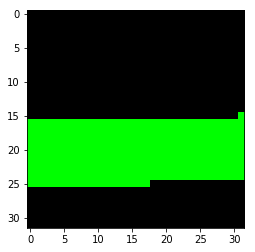

In [28]:
# Compute Reference intra class variance and inter-class variance
X = []
for i in xrange(10):
    X.append([])
for x, y in ReferenceDataset(args.dataset):
    X[y].append(x)
for i in xrange(10):
    X[i] = torch.cat(X[i]).view(len(X[i]), -1)
    
for i in xrange(10):
    mean = X[i].mean(0)
    var = ((X[i]-mean)**2).sum(1).mean()
    print ('Variance class {}: {:.2f}'.format(i, var))
    
all_X = torch.cat(X)
mean = all_X.mean(0)
var = ((all_X-mean)**2).sum(1).mean()
print ('Inter-class variance: {:.2f}'.format(var))

if args.dataset == 'mnist':
    plt.imshow(X[5].mean(0).view(28,28))
elif  args.dataset == 'svhn':
    plt.imshow(X[5].mean(0).view(3, 32, 32).numpy().transpose(1, 2, 0))


# MMD

In [29]:
# MMD
class MMDKernel(object):
    def dot(self, x1, x2):
        raise Exception('Implement')

    def h(self, X1, Y1, X2, Y2):
        k_X1_X2 = self.dot(X1, X2)
        k_Y1_Y2 = self.dot(Y1, Y2)
        k_X1_Y2 = self.dot(X1, Y2)
        k_X2_Y1 = self.dot(X2, Y1)
        stat =  k_X1_X2 + k_Y1_Y2 - k_X1_Y2 - k_X2_Y1
        return stat
    
    def split(self, X):
        return X[0::2], X[1::2]
    
        
class GaussianKernel(MMDKernel):
    def __init__(self, sigma=1.):
        self.sigma = sigma
        
    def dot(self, x1, x2):
        x1 = x1.view(len(x1), -1)  # flatten
        x2 = x2.view(len(x2), -1)  # flatten
        
        delta = x1-x2
        dot = (delta*delta).mean(1)
        return np.exp(-dot / self.sigma**2)


class ZeroOneKernel(MMDKernel):
    def dot(self, y1, y2):
        # Return 1 or less (shouldn't be zero)
        return np.exp(-(y1 != y2).float())

    
class JointKernel(MMDKernel):
    def __init__(self, kx, ky):
        self.kx = kx
        self.ky = ky
        
    def dot(self, (x1, y1), (x2, y2)):
        dotx = self.kx.dot(x1, x2)
        doty = self.ky.dot(y1, y2)
        return dotx * doty
    
    def split(self, (X_image, X_label)):
        X1 = (X_image[0::2], X_label[0::2])
        X2 = (X_image[1::2], X_label[1::2])
        return X1, X2
        
# Here X~p and Y~q
def linear_mmd(kernel, X, Y):
    # linear time unbiased estimator
    # h((xi,yi), (xj, yj)) = k(xi,xj)+k(yi,yj)-k(xi,yj)-k(xj,yi)
    assert len(X)==len(Y)

    X1, X2 = kernel.split(X)
    Y1, Y2 = kernel.split(Y)

    hs = kernel.h(X1, Y1, X2, Y2) 
    mmd2 = hs.mean()
    
    return mmd2
    
    
def linear_mmd_validation(kernel, X_train, Y_train, X_val, Y_val):
    '''
    this should return a lower bound on MMD,
    it takes the witness function computed on the training empirical distributions X_train, Y_train
    and applies it on the validation empirical distributions X_val, Y_val
    '''
    assert len(X_train)==len(Y_train)
    assert len(X_val)==len(Y_val)
    assert len(X_train)==len(X_val)
    
    hs = kernel.h(X_train, Y_train, X_val, Y_val) 
    mmd2 = hs.mean()
    
    return mmd2
    
# Independence test

def compute_mmd(corruptions, joint_kernel, epochs=1, reference=False, batch_size=1000):

    all_mmds_train = []
    all_mmds_test = []
    #all_mmds_std = []
    

    for corruption in corruptions:

        print ('Corruption {}'.format(corruption))

        if not reference:
            # IMPORTANT FOR SVHN : DO NOT SPECIFY CLASSES=10 BECAUSE
            # LABEL DISTRIBUTION IS NON-UNIFORM
            train_corrupted = CorruptedDataset(train_dataset, corruption)  # X partially dependent on Y
            train_random = CorruptedDataset(train_dataset, 1)  # X totally independent Y
            # for validaiton only
            #test_corrupted = CorruptedDataset(test_dataset, corruption, classes=10)
            #test_random = CorruptedDataset(test_dataset, 1, classes=10)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)  # X partially dependent on Y
            train_random = CorruptedDataset(ReferenceDataset(args.dataset), 1)  # X totally independent Y
            # for validation only
            #test_corrupted = CorruptedDataset(ReferenceDataset(), corruption)
            #test_random = CorruptedDataset(ReferenceDataset(), 1, classes=10)  # X totally independent Y
            
        train_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=batch_size, drop_last=True, shuffle=True, **kwargs)
        train_random_loader = torch.utils.data.DataLoader(train_random, batch_size=batch_size, drop_last=True, shuffle=True, **kwargs)
        # for validation MMD
        #test_corrupted_loader = torch.utils.data.DataLoader(train_corrupted, batch_size=batch_size, shuffle=True, **kwargs)
        #test_random_loader = torch.utils.data.DataLoader(test_random, batch_size=batch_size, shuffle=True, **kwargs)
        #test_corrupted_iter = make_infinite(test_corrupted_loader)
        #test_random_iter = make_infinite(test_random_loader)
        
        
        linear_mmds_train = []
        linear_mmds_val = []
        for epoch in xrange(1, epochs+1):
            # Can run many times to reduce variance
            for batch_idx, (X, Y) in enumerate(zip(train_corrupted_loader, train_random_loader)):
                
                mmd_train = linear_mmd(joint_kernel, X, Y)
                
                # for validation only
                #X_val, Y_val = test_corrupted_iter.next(), test_random_iter.next()
                #mmd_val = linear_mmd_validation(joint_kernel, X, Y, X_val, Y_val)
                               
                
                linear_mmds_train.append(mmd_train.item())
                #linear_mmds_val.append(mmd_val.item())
                
                if batch_idx % 100 == 0 or batch_idx==len(train_corrupted_loader)-1:              
                    print ('Epoch {}/{} Batch {}/{} MMD train {:.5} '.format(
                        epoch, epochs, batch_idx, len(train_corrupted_loader), 
                        np.mean(linear_mmds_train)))
        all_mmds_train.append([np.mean(linear_mmds_train)])
        all_mmds_test.append([np.mean(linear_mmds_train)])  # THIS IS WRONG BUT VALIDATION MMD IS ANNOYING TO COMPUTE
        #all_mmds_test.append([np.mean(linear_mmds_val)])
        #all_mmds_std.append([np.std(linear_mmds)])

    return all_mmds_train, all_mmds_test         

MMD_Epochs = 100
kernel_x = GaussianKernel()
kernel_y = ZeroOneKernel()
joint_kernel = JointKernel(kernel_x, kernel_y)

In [30]:
all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=MMD_Epochs, reference=False)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}
torch.save(data, '{}_real_mmd.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
Epoch 1/100 Batch 0/46 MMD train -0.010551 
Epoch 1/100 Batch 45/46 MMD train -0.0015497 
Epoch 2/100 Batch 0/46 MMD train -0.0011117 
Epoch 2/100 Batch 45/46 MMD train -0.00041555 
Epoch 3/100 Batch 0/46 MMD train -0.00013558 
Epoch 3/100 Batch 45/46 MMD train -0.00095186 
Epoch 4/100 Batch 0/46 MMD train -0.0011353 
Epoch 4/100 Batch 45/46 MMD train -0.0020143 
Epoch 5/100 Batch 0/46 MMD train -0.0020543 
Epoch 5/100 Batch 45/46 MMD train -0.0022217 
Epoch 6/100 Batch 0/46 MMD train -0.0022813 
Epoch 6/100 Batch 45/46 MMD train -0.001697 
Epoch 7/100 Batch 0/46 MMD train -0.0017628 
Epoch 7/100 Batch 45/46 MMD train -0.0015101 
Epoch 8/100 Batch 0/46 MMD train -0.0014583 
Epoch 8/100 Batch 45/46 MMD train -0.0014477 
Epoch 9/100 Batch 0/46 MMD train -0.0014133 
Epoch 9/100 Batch 45/46 MMD train -0.0013758 
Epoch 10/100 Batch 0/46 MMD train -0.0013944 
Epoch 1

Epoch 87/100 Batch 0/46 MMD train 0.00011329 
Epoch 87/100 Batch 45/46 MMD train 0.00010503 
Epoch 88/100 Batch 0/46 MMD train 0.00011221 
Epoch 88/100 Batch 45/46 MMD train 9.5762e-05 
Epoch 89/100 Batch 0/46 MMD train 9.067e-05 
Epoch 89/100 Batch 45/46 MMD train 6.5918e-05 
Epoch 90/100 Batch 0/46 MMD train 7.7914e-05 
Epoch 90/100 Batch 45/46 MMD train 5.9416e-05 
Epoch 91/100 Batch 0/46 MMD train 5.539e-05 
Epoch 91/100 Batch 45/46 MMD train 6.7223e-05 
Epoch 92/100 Batch 0/46 MMD train 6.6664e-05 
Epoch 92/100 Batch 45/46 MMD train 2.982e-05 
Epoch 93/100 Batch 0/46 MMD train 1.886e-05 
Epoch 93/100 Batch 45/46 MMD train 4.4306e-06 
Epoch 94/100 Batch 0/46 MMD train -1.6594e-06 
Epoch 94/100 Batch 45/46 MMD train 4.6755e-05 
Epoch 95/100 Batch 0/46 MMD train 4.3333e-05 
Epoch 95/100 Batch 45/46 MMD train 3.9811e-05 
Epoch 96/100 Batch 0/46 MMD train 3.6771e-05 
Epoch 96/100 Batch 45/46 MMD train 4.9712e-05 
Epoch 97/100 Batch 0/46 MMD train 5.3139e-05 
Epoch 97/100 Batch 45/46 MM

Epoch 73/100 Batch 45/46 MMD train 9.0268e-05 
Epoch 74/100 Batch 0/46 MMD train 8.6315e-05 
Epoch 74/100 Batch 45/46 MMD train 7.5775e-05 
Epoch 75/100 Batch 0/46 MMD train 7.1639e-05 
Epoch 75/100 Batch 45/46 MMD train 8.6056e-05 
Epoch 76/100 Batch 0/46 MMD train 8.5989e-05 
Epoch 76/100 Batch 45/46 MMD train 7.3632e-05 
Epoch 77/100 Batch 0/46 MMD train 7.3274e-05 
Epoch 77/100 Batch 45/46 MMD train 3.6008e-05 
Epoch 78/100 Batch 0/46 MMD train 3.3359e-05 
Epoch 78/100 Batch 45/46 MMD train 1.7156e-05 
Epoch 79/100 Batch 0/46 MMD train 1.5727e-05 
Epoch 79/100 Batch 45/46 MMD train -9.0698e-06 
Epoch 80/100 Batch 0/46 MMD train -1.5477e-05 
Epoch 80/100 Batch 45/46 MMD train -6.6143e-05 
Epoch 81/100 Batch 0/46 MMD train -6.1814e-05 
Epoch 81/100 Batch 45/46 MMD train -8.0614e-05 
Epoch 82/100 Batch 0/46 MMD train -7.5457e-05 
Epoch 82/100 Batch 45/46 MMD train -0.00010958 
Epoch 83/100 Batch 0/46 MMD train -0.00011265 
Epoch 83/100 Batch 45/46 MMD train -0.00016445 
Epoch 84/100 B

Epoch 60/100 Batch 0/46 MMD train -0.00016113 
Epoch 60/100 Batch 45/46 MMD train -0.00021144 
Epoch 61/100 Batch 0/46 MMD train -0.0002207 
Epoch 61/100 Batch 45/46 MMD train -0.00024987 
Epoch 62/100 Batch 0/46 MMD train -0.00024474 
Epoch 62/100 Batch 45/46 MMD train -0.00028016 
Epoch 63/100 Batch 0/46 MMD train -0.00027724 
Epoch 63/100 Batch 45/46 MMD train -0.00031927 
Epoch 64/100 Batch 0/46 MMD train -0.00031228 
Epoch 64/100 Batch 45/46 MMD train -0.00028258 
Epoch 65/100 Batch 0/46 MMD train -0.00028653 
Epoch 65/100 Batch 45/46 MMD train -0.00024881 
Epoch 66/100 Batch 0/46 MMD train -0.00024682 
Epoch 66/100 Batch 45/46 MMD train -0.00025314 
Epoch 67/100 Batch 0/46 MMD train -0.00024961 
Epoch 67/100 Batch 45/46 MMD train -0.00025654 
Epoch 68/100 Batch 0/46 MMD train -0.0002665 
Epoch 68/100 Batch 45/46 MMD train -0.00027586 
Epoch 69/100 Batch 0/46 MMD train -0.00027402 
Epoch 69/100 Batch 45/46 MMD train -0.00026295 
Epoch 70/100 Batch 0/46 MMD train -0.00026683 
Epoch

Epoch 46/100 Batch 45/46 MMD train 0.00055729 
Epoch 47/100 Batch 0/46 MMD train 0.00055361 
Epoch 47/100 Batch 45/46 MMD train 0.00057436 
Epoch 48/100 Batch 0/46 MMD train 0.00056205 
Epoch 48/100 Batch 45/46 MMD train 0.00057049 
Epoch 49/100 Batch 0/46 MMD train 0.00056869 
Epoch 49/100 Batch 45/46 MMD train 0.00057241 
Epoch 50/100 Batch 0/46 MMD train 0.00057397 
Epoch 50/100 Batch 45/46 MMD train 0.00055028 
Epoch 51/100 Batch 0/46 MMD train 0.00054315 
Epoch 51/100 Batch 45/46 MMD train 0.00053828 
Epoch 52/100 Batch 0/46 MMD train 0.0005423 
Epoch 52/100 Batch 45/46 MMD train 0.00047713 
Epoch 53/100 Batch 0/46 MMD train 0.00048706 
Epoch 53/100 Batch 45/46 MMD train 0.00053187 
Epoch 54/100 Batch 0/46 MMD train 0.00054078 
Epoch 54/100 Batch 45/46 MMD train 0.00058368 
Epoch 55/100 Batch 0/46 MMD train 0.00059116 
Epoch 55/100 Batch 45/46 MMD train 0.0005789 
Epoch 56/100 Batch 0/46 MMD train 0.00058347 
Epoch 56/100 Batch 45/46 MMD train 0.00053294 
Epoch 57/100 Batch 0/46 M

Epoch 34/100 Batch 0/46 MMD train 0.0001215 
Epoch 34/100 Batch 45/46 MMD train 0.00016335 
Epoch 35/100 Batch 0/46 MMD train 0.00014843 
Epoch 35/100 Batch 45/46 MMD train 0.00014202 
Epoch 36/100 Batch 0/46 MMD train 0.00015392 
Epoch 36/100 Batch 45/46 MMD train 0.00012386 
Epoch 37/100 Batch 0/46 MMD train 0.00013605 
Epoch 37/100 Batch 45/46 MMD train 0.00015541 
Epoch 38/100 Batch 0/46 MMD train 0.00015721 
Epoch 38/100 Batch 45/46 MMD train 3.5272e-05 
Epoch 39/100 Batch 0/46 MMD train 4.8048e-05 
Epoch 39/100 Batch 45/46 MMD train -4.4736e-05 
Epoch 40/100 Batch 0/46 MMD train -3.9e-05 
Epoch 40/100 Batch 45/46 MMD train -4.5075e-05 
Epoch 41/100 Batch 0/46 MMD train -4.0956e-05 
Epoch 41/100 Batch 45/46 MMD train -5.1635e-05 
Epoch 42/100 Batch 0/46 MMD train -6.4162e-05 
Epoch 42/100 Batch 45/46 MMD train -0.00011555 
Epoch 43/100 Batch 0/46 MMD train -0.00010975 
Epoch 43/100 Batch 45/46 MMD train -9.9679e-05 
Epoch 44/100 Batch 0/46 MMD train -9.132e-05 
Epoch 44/100 Batch 

In [31]:
all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=MMD_Epochs, reference=True)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}
torch.save(data, '{}_reference_mmd.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
Epoch 1/100 Batch 0/60 MMD train 0.023272 
Epoch 1/100 Batch 59/60 MMD train 0.0083118 
Epoch 2/100 Batch 0/60 MMD train 0.0084755 
Epoch 2/100 Batch 59/60 MMD train 0.0095841 
Epoch 3/100 Batch 0/60 MMD train 0.0095954 
Epoch 3/100 Batch 59/60 MMD train 0.010367 
Epoch 4/100 Batch 0/60 MMD train 0.010405 
Epoch 4/100 Batch 59/60 MMD train 0.0098786 
Epoch 5/100 Batch 0/60 MMD train 0.0098191 
Epoch 5/100 Batch 59/60 MMD train 0.0095885 
Epoch 6/100 Batch 0/60 MMD train 0.0095647 
Epoch 6/100 Batch 59/60 MMD train 0.0097082 
Epoch 7/100 Batch 0/60 MMD train 0.0096997 
Epoch 7/100 Batch 59/60 MMD train 0.0099827 
Epoch 8/100 Batch 0/60 MMD train 0.010008 
Epoch 8/100 Batch 59/60 MMD train 0.01025 
Epoch 9/100 Batch 0/60 MMD train 0.010262 
Epoch 9/100 Batch 59/60 MMD train 0.010196 
Epoch 10/100 Batch 0/60 MMD train 0.010225 
Epoch 10/100 Batch 59/60 MMD train 0

Epoch 91/100 Batch 0/60 MMD train 0.01003 
Epoch 91/100 Batch 59/60 MMD train 0.010041 
Epoch 92/100 Batch 0/60 MMD train 0.010037 
Epoch 92/100 Batch 59/60 MMD train 0.010034 
Epoch 93/100 Batch 0/60 MMD train 0.010032 
Epoch 93/100 Batch 59/60 MMD train 0.010044 
Epoch 94/100 Batch 0/60 MMD train 0.010042 
Epoch 94/100 Batch 59/60 MMD train 0.010036 
Epoch 95/100 Batch 0/60 MMD train 0.010034 
Epoch 95/100 Batch 59/60 MMD train 0.010024 
Epoch 96/100 Batch 0/60 MMD train 0.01002 
Epoch 96/100 Batch 59/60 MMD train 0.01 
Epoch 97/100 Batch 0/60 MMD train 0.010001 
Epoch 97/100 Batch 59/60 MMD train 0.0099744 
Epoch 98/100 Batch 0/60 MMD train 0.0099705 
Epoch 98/100 Batch 59/60 MMD train 0.0099876 
Epoch 99/100 Batch 0/60 MMD train 0.0099877 
Epoch 99/100 Batch 59/60 MMD train 0.0099644 
Epoch 100/100 Batch 0/60 MMD train 0.0099632 
Epoch 100/100 Batch 59/60 MMD train 0.009944 
Corruption 0.25
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, 

Epoch 80/100 Batch 59/60 MMD train 0.0058564 
Epoch 81/100 Batch 0/60 MMD train 0.0058574 
Epoch 81/100 Batch 59/60 MMD train 0.0058511 
Epoch 82/100 Batch 0/60 MMD train 0.0058524 
Epoch 82/100 Batch 59/60 MMD train 0.0058387 
Epoch 83/100 Batch 0/60 MMD train 0.005839 
Epoch 83/100 Batch 59/60 MMD train 0.0058393 
Epoch 84/100 Batch 0/60 MMD train 0.005841 
Epoch 84/100 Batch 59/60 MMD train 0.0058501 
Epoch 85/100 Batch 0/60 MMD train 0.0058472 
Epoch 85/100 Batch 59/60 MMD train 0.0058276 
Epoch 86/100 Batch 0/60 MMD train 0.0058262 
Epoch 86/100 Batch 59/60 MMD train 0.0058591 
Epoch 87/100 Batch 0/60 MMD train 0.0058621 
Epoch 87/100 Batch 59/60 MMD train 0.0058322 
Epoch 88/100 Batch 0/60 MMD train 0.0058313 
Epoch 88/100 Batch 59/60 MMD train 0.0058113 
Epoch 89/100 Batch 0/60 MMD train 0.0058159 
Epoch 89/100 Batch 59/60 MMD train 0.0058113 
Epoch 90/100 Batch 0/60 MMD train 0.0058115 
Epoch 90/100 Batch 59/60 MMD train 0.005838 
Epoch 91/100 Batch 0/60 MMD train 0.0058399 
Ep

Epoch 70/100 Batch 0/60 MMD train 0.0023814 
Epoch 70/100 Batch 59/60 MMD train 0.0023325 
Epoch 71/100 Batch 0/60 MMD train 0.002328 
Epoch 71/100 Batch 59/60 MMD train 0.0023405 
Epoch 72/100 Batch 0/60 MMD train 0.0023411 
Epoch 72/100 Batch 59/60 MMD train 0.0023571 
Epoch 73/100 Batch 0/60 MMD train 0.0023593 
Epoch 73/100 Batch 59/60 MMD train 0.0023512 
Epoch 74/100 Batch 0/60 MMD train 0.0023593 
Epoch 74/100 Batch 59/60 MMD train 0.0023906 
Epoch 75/100 Batch 0/60 MMD train 0.0023929 
Epoch 75/100 Batch 59/60 MMD train 0.0023412 
Epoch 76/100 Batch 0/60 MMD train 0.0023395 
Epoch 76/100 Batch 59/60 MMD train 0.002355 
Epoch 77/100 Batch 0/60 MMD train 0.0023602 
Epoch 77/100 Batch 59/60 MMD train 0.0023793 
Epoch 78/100 Batch 0/60 MMD train 0.0023747 
Epoch 78/100 Batch 59/60 MMD train 0.0023916 
Epoch 79/100 Batch 0/60 MMD train 0.0023925 
Epoch 79/100 Batch 59/60 MMD train 0.0024144 
Epoch 80/100 Batch 0/60 MMD train 0.0024087 
Epoch 80/100 Batch 59/60 MMD train 0.0024036 
E

Epoch 58/100 Batch 0/60 MMD train 0.00023797 
Epoch 58/100 Batch 59/60 MMD train 0.00025316 
Epoch 59/100 Batch 0/60 MMD train 0.00025158 
Epoch 59/100 Batch 59/60 MMD train 0.00025215 
Epoch 60/100 Batch 0/60 MMD train 0.00025419 
Epoch 60/100 Batch 59/60 MMD train 0.00024409 
Epoch 61/100 Batch 0/60 MMD train 0.00024915 
Epoch 61/100 Batch 59/60 MMD train 0.00027624 
Epoch 62/100 Batch 0/60 MMD train 0.00027352 
Epoch 62/100 Batch 59/60 MMD train 0.00031383 
Epoch 63/100 Batch 0/60 MMD train 0.00031187 
Epoch 63/100 Batch 59/60 MMD train 0.00032274 
Epoch 64/100 Batch 0/60 MMD train 0.00032508 
Epoch 64/100 Batch 59/60 MMD train 0.0003221 
Epoch 65/100 Batch 0/60 MMD train 0.00031745 
Epoch 65/100 Batch 59/60 MMD train 0.00033205 
Epoch 66/100 Batch 0/60 MMD train 0.00033104 
Epoch 66/100 Batch 59/60 MMD train 0.00035145 
Epoch 67/100 Batch 0/60 MMD train 0.00035112 
Epoch 67/100 Batch 59/60 MMD train 0.00033318 
Epoch 68/100 Batch 0/60 MMD train 0.00032952 
Epoch 68/100 Batch 59/60 

Epoch 45/100 Batch 0/60 MMD train 3.6849e-05 
Epoch 45/100 Batch 59/60 MMD train -1.2838e-05 
Epoch 46/100 Batch 0/60 MMD train -9.4392e-06 
Epoch 46/100 Batch 59/60 MMD train 4.7784e-05 
Epoch 47/100 Batch 0/60 MMD train 4.2129e-05 
Epoch 47/100 Batch 59/60 MMD train 4.4607e-05 
Epoch 48/100 Batch 0/60 MMD train 4.8812e-05 
Epoch 48/100 Batch 59/60 MMD train 4.9882e-05 
Epoch 49/100 Batch 0/60 MMD train 5.2741e-05 
Epoch 49/100 Batch 59/60 MMD train -2.1453e-05 
Epoch 50/100 Batch 0/60 MMD train -1.6598e-05 
Epoch 50/100 Batch 59/60 MMD train -4.904e-05 
Epoch 51/100 Batch 0/60 MMD train -6.359e-05 
Epoch 51/100 Batch 59/60 MMD train -9.2654e-05 
Epoch 52/100 Batch 0/60 MMD train -9.1724e-05 
Epoch 52/100 Batch 59/60 MMD train -8.2581e-05 
Epoch 53/100 Batch 0/60 MMD train -8.4563e-05 
Epoch 53/100 Batch 59/60 MMD train -8.5058e-05 
Epoch 54/100 Batch 0/60 MMD train -8.7978e-05 
Epoch 54/100 Batch 59/60 MMD train -8.2524e-05 
Epoch 55/100 Batch 0/60 MMD train -8.639e-05 
Epoch 55/100 

all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=10, reference=True)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}
torch.save(data, '{}_reference_mmd.pt'.format(args.dataset))

all_mmds_train, all_mmds_test = compute_mmd(corruptions, joint_kernel, epochs=1, reference=False)
data = {'train': all_mmds_train,
       'test': all_mmds_test,
       'corruptions': corruptions}


# Random Forest


In [32]:
def dataset_to_numpy(dataset):    
    X = []
    Y = []
    for i, (x, y) in enumerate(dataset):
        X.append(x.numpy().flatten())
        if not isinstance(y, int):
            y = y.item()
        Y.append(y)
    
        if i % 10000 ==0 :
            print ('{}/{}'.format(i, len(dataset)))
    X = np.asarray(X)
    Y = np.asarray(Y)
    # shuffle
    idx = np.arange(len(X))
    np.random.shuffle(idx)
    # make contiguous
    X = X[idx].copy()
    Y = Y[idx].copy()
    
    return X, Y


def get_regularized_logloss(Y_prob, Y_test, regularize=0.01):
    uniform = np.ones((len(Y_prob), 10)) / 10.
    Y_regularized = regularize*uniform+(1-regularize)*Y_prob
    logloss = -np.log(Y_regularized)[range(len(Y_test)), Y_test].mean()
    #print (Y_regularized.sum(1))
    return logloss

    
def compute_rf(corruptions, reference=False):

    all_train_losses = []
    all_test_losses = []
    for corruption in corruptions:

        print ('Corruption {}'.format(corruption))

        if not reference:
            train_corrupted = CorruptedDataset(train_dataset, corruption)  # X partially dependent on Y
            test_corrupted = CorruptedDataset(test_dataset, corruption)
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)  # X partially dependent on Y
            test_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)
        
        X_train, Y_train = dataset_to_numpy(train_corrupted)
        X_test, Y_test = dataset_to_numpy(test_corrupted)

        print ('Fitting random forest')
        clf = RandomForestClassifier()
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print ('accuracy', (Y_pred == Y_test).mean())

        # Log loss train
        Y_prob_train = clf.predict_proba(X_train)
        logloss_train = get_regularized_logloss(Y_prob_train, Y_train)

        # Log loss test
        Y_prob_test = clf.predict_proba(X_test)
        logloss_test = get_regularized_logloss(Y_prob_test, Y_test)

        all_test_losses.append(logloss_test)
        all_train_losses.append(logloss_train)

        print ('Log loss Train {}'.format(logloss_train))
        print ('Log loss Test {}'.format(logloss_test))

    return all_train_losses, all_test_losses

In [33]:
all_train_losses, all_test_losses = compute_rf(corruptions, reference=False)

data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_rf.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
0/15950
10000/15950
Fitting random forest
accuracy 0.49454545454545457
Log loss Train 0.313459950678
Log loss Test 1.92962339132
Corruption 0.25
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
0/15950
10000/15950
Fitting random forest
accuracy 0.3220689655172414
Log loss Train 0.372374851264
Log loss Test 2.70305580786
Corruption 0.5
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
0/15950
10000/15950
Fitting random forest
accuracy 0.19247648902821315
Log loss Train 0.41349973893
Log loss Test 3.24708106856
Corruption 0.75
Corrupting dataset (SHUFFLE labels, not always un

In [34]:
all_train_losses, all_test_losses = compute_rf(corruptions, reference=True)

data = {'train': all_train_losses,
       'test': all_test_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_rf.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 1.0
Log loss Train 0.00904074465215
Log loss Test 0.00904074465215
Corruption 0.25
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitting random forest
accuracy 0.7762333333333333
Log loss Train 1.01787518281
Log loss Test 1.02411239671
Corruption 0.5
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Fitti

# Wasserstein

In [35]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
import scipy


def log_sum_exp(u, dim):
    # Reduce log sum exp along axis
    u_max, __ = u.max(dim=dim, keepdim=True)
    log_sum_exp_u = torch.log(torch.exp(u - u_max).sum(dim)) + u_max.sum(dim)
    return log_sum_exp_u


def compute_sinkhorn_stable(m, r=None, c=None, log_v=None, regularization=100., iterations=40):
    # If no distributions are given, consider two uniform histograms
    if r is None:
        r = torch.ones(m.size()[0]).to(m.device) / m.size()[0]
    if c is None:
        c = torch.ones(m.size()[1]).to(m.device) / m.size()[1]
    log_r = torch.log(r)
    log_c = torch.log(c)

    # Initialize dual variable v (u is implicitly defined in the loop)
    if log_v is None:
        log_v = torch.zeros(m.size()[1]).to(m.device)  # ==torch.log(torch.ones(m.size()[1]))

    # Exponentiate the pairwise distance matrix
    log_K = -regularization * m

    # Main loop
    for i in xrange(iterations):
        # Match r marginals
        log_u = log_r - log_sum_exp(log_K + log_v[None, :], dim=1)

        # Match c marginals
        log_v = log_c - log_sum_exp(log_u[:, None] + log_K, dim=0)

    # Compute optimal plan, cost, return everything
    log_P = log_u[:, None] + log_K + log_v[None, :]
    P = torch.exp(log_P)  # transport plan
    dst = (P * m).sum()

    return dst, P, log_P, log_u, log_v


def compute_wasserstein(corruptions, reference=False, N=1000):

    all_train_losses = []

    for corruption in corruptions:
        
        print ('Corruption {}'.format(corruption))
        
        if not reference:
            
            # IMPORTANT FOR SVHN : DO NOT SPECIFY CLASSES=10 BECAUSE
            # LABEL DISTRIBUTION IS NON-UNIFORM            
            train_corrupted = CorruptedDataset(train_dataset, corruption)  # X partially dependent on Y
            train_random = CorruptedDataset(train_dataset, 1)  # X totally independent Y
        else:
            train_corrupted = CorruptedDataset(ReferenceDataset(args.dataset), corruption)  # X partially dependent on Y
            train_random = CorruptedDataset(ReferenceDataset(args.dataset), 1)  # X totally independent Y            
            
        # Weight matrix
        X_train, Y_train = dataset_to_numpy(train_corrupted)
        X_random, Y_random = dataset_to_numpy(train_random)
        #X_test, Y_test = dataset_to_numpy(test_corrupted)

        # limit the number of points
        X_train = X_train[:N]
        X_random = X_random[:N]
        Y_train = Y_train[:N]
        Y_random = Y_random[:N]

        xdst = cdist(X_train, X_random) / 28.
        ydst = (Y_train[:, None] != Y_random[None, :]).astype(float)
        totaldst = xdst + ydst

        print ('Computing Sinkhorn')
        
        totaldst = torch.from_numpy(totaldst).float()
        dst, P, log_P, log_u, log_v = compute_sinkhorn_stable(totaldst, regularization=100.)
        
        all_train_losses.append(dst.item())
        
        print ('dst {:.3f}'.format(dst.item()))
        
    return all_train_losses


Wasserstein_N = 6000 # limit to those examples

In [36]:
all_train_losses = compute_wasserstein(corruptions, reference=False, N=Wasserstein_N)
data = {'train': all_train_losses,
       'test': all_train_losses,
       'corruptions': corruptions}
torch.save(data, '{}_real_wasserstein.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
Computing Sinkhorn
dst 0.267
Corruption 0.25
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
Computing Sinkhorn
dst 0.264
Corruption 0.5
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
Computing Sinkhorn
dst 0.264
Corruption 0.75
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/46590
10000/46590
20000/46590
30000/46590
40000/46590
0/46590
100

In [37]:
all_train_losses = compute_wasserstein(corruptions, reference=True, N=Wasserstein_N)
data = {'train': all_train_losses,
       'test': all_train_losses,
       'corruptions': corruptions}
torch.save(data, '{}_reference_wasserstein.pt'.format(args.dataset))

Corruption 0.0
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Computing Sinkhorn
dst 0.801
Corruption 0.25
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Computing Sinkhorn
dst 0.604
Corruption 0.5
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always uniform)
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
0/60000
10000/60000
20000/60000
30000/60000
40000/60000
50000/60000
Computing Sinkhorn
dst 0.278
Corruption 0.75
Corrupting dataset (SHUFFLE labels, not always uniform)
Corrupting dataset (SHUFFLE labels, not always unif

# Plot All MNIST/SVHN

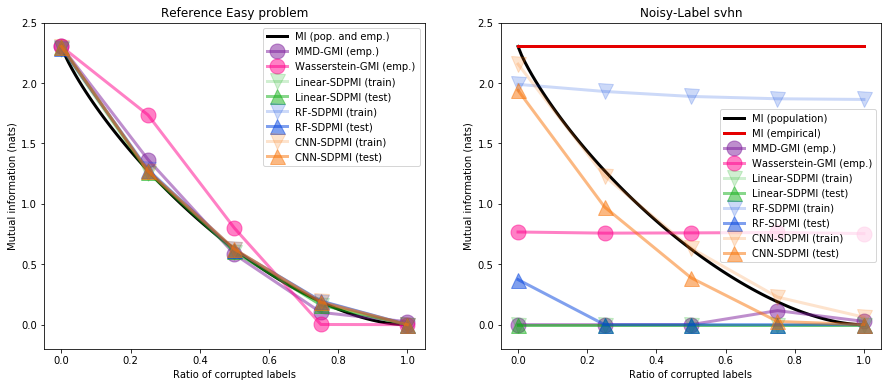

In [11]:
def plot_data(data, label, color, marker=None, **kwargs):
    train_mi = np.log(10) - np.asarray(data['train'])
    test_mi = np.log(10) - np.asarray(data['test'])
    plt.plot(data['corruptions'], np.maximum(train_mi, 0),
             label='{} (train)'.format(label), color=color, 
             alpha=0.2, linewidth=3, markersize=15, marker='v', **kwargs)
    plt.plot(data['corruptions'], np.maximum(test_mi, 0), 
             label='{} (test)'.format(label), color=color, 
             alpha=0.5, linewidth=3, markersize=15, marker='^', **kwargs)
    
def plot_data2(data, label, color, scale=1., marker=None, **kwargs):
    plt.plot(data['corruptions'], scale*np.maximum(data['train'], 0),
             label='{} (emp.)'.format(label), markersize=15, color=color, 
             marker='o', alpha=0.5, linewidth=3, **kwargs)#, ls='dashed')    

plt.figure(figsize=(15, 6))
MMD_max = np.max(torch.load('{}_reference_mmd.pt'.format(args.dataset))['train'])
MMD_scaling = np.log(10) / MMD_max
Wasserstein_max = np.max(torch.load('{}_reference_wasserstein.pt'.format(args.dataset))['train'])
Wasserstein_scaling = np.log(10) / Wasserstein_max
    
plt.subplot(121)
    

# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='MI (pop. and emp.)', color='xkcd:black', linewidth=3)
#plt.plot(alpha,empirical_mi, label='Empirical MI', color='xkcd:red', linewidth=3)
    
plot_data2(torch.load('{}_reference_mmd.pt'.format(args.dataset)), 'MMD-GMI', 'xkcd:purple', MMD_scaling, marker='o')
plot_data2(torch.load('{}_reference_wasserstein.pt'.format(args.dataset)), 'Wasserstein-GMI', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
plot_data(torch.load('{}_reference_logistic.pt'.format(args.dataset)), 'Linear-SDPMI', 'xkcd:green', marker='s')
plot_data(torch.load('{}_reference_rf.pt'.format(args.dataset)), 'RF-SDPMI', 'xkcd:blue', marker=11)
plot_data(torch.load('{}_reference_cnn.pt'.format(args.dataset)), 'CNN-SDPMI', 'xkcd:orange', marker=10)

    
plt.title('Reference Easy problem')
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()




plt.subplot(122)


# Reference population and empirical
alpha = np.linspace(0, 1, 100)
k = 10
true_mi = corruption_to_mi(alpha)
empirical_mi = np.ones_like(alpha)*np.log(10)
plt.plot(alpha, true_mi, label='MI (population)', color='xkcd:black', linewidth=3)
plt.plot(alpha,empirical_mi, label='MI (empirical)', color='xkcd:red', linewidth=3)
   
plot_data2(torch.load('{}_real_mmd.pt'.format(args.dataset)), 'MMD-GMI', 'xkcd:purple', MMD_scaling, marker='o')
plot_data2(torch.load('{}_real_wasserstein.pt'.format(args.dataset)), 'Wasserstein-GMI', 'xkcd:hot pink', Wasserstein_scaling, marker='o')
plot_data(torch.load('{}_real_logistic.pt'.format(args.dataset)), 'Linear-SDPMI', 'xkcd:green', marker='s')
plot_data(torch.load('{}_real_rf.pt'.format(args.dataset)), 'RF-SDPMI', 'xkcd:blue', marker=11)
plot_data(torch.load('{}_real_cnn.pt'.format(args.dataset)), 'CNN-SDPMI', 'xkcd:orange', marker=10)


plt.title('Noisy-Label {}'.format(args.dataset))
plt.xlabel('Ratio of corrupted labels')
plt.ylabel('Mutual information (nats)')
plt.ylim(-0.2, 2.5)
plt.legend()

plt.savefig('pmi_{}.pdf'.format(args.dataset))


